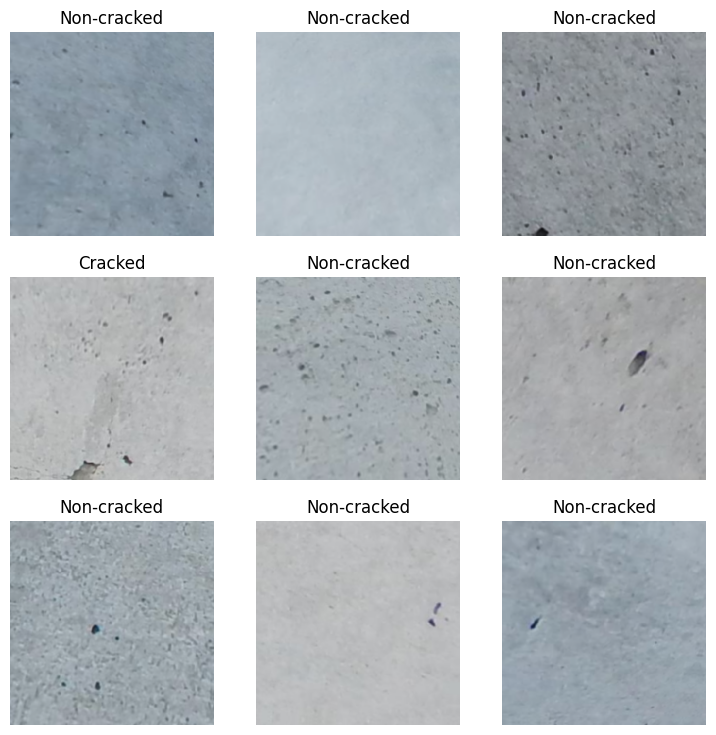

In [1]:
from fastai.vision.all import *

path = Path('/home/dnth/Desktop/sdnet-detect-dataset/Walls')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75)]
)

dls = dblock.dataloaders(path, bs=64)
dls.show_batch()

In [2]:
learn = vision_learner(dls, "resnet50", metrics=[error_rate, accuracy])

In [3]:
import torch
import timm
from minlora import add_lora, apply_to_lora, disable_lora, enable_lora, get_lora_params, merge_lora, name_is_lora, remove_lora, load_multiple_lora, select_lora

In [4]:
from minlora import LoRAParametrization

config = { 
    nn.Linear: {
        "weight": partial(LoRAParametrization.from_linear, rank=4),
    },
    # nn.Conv2d: {
    #     "weight": partial(LoRAParametrization.from_conv2d, rank=4),
    # },
}

add_lora(learn.model, lora_config=config)

In [5]:
learn.model

Sequential(
  (0): TimmBody(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [6]:
learn.summary()

/home/dnth/anaconda3/envs/fastai_ssl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

In [7]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.669373,0.476625,0.169286,0.830714,00:44
1,0.438028,0.391988,0.143093,0.856907,00:43
2,0.386929,0.392335,0.138406,0.861594,00:43
